In [1]:
# Built-in
from pathlib import Path
import json

# Third-party
from matplotlib import pyplot as plt
from matplotlib import style, cm
from scipy.stats import gmean, fisher_exact, ttest_1samp
import seaborn as sns
import pandas as pd
import numpy as np
import feather

workdir = Path("/casa/joha/projects/polya/works")

work = "jp3"

In [2]:
samples = {
    'mh1': ["Input", "LARP1"],
    # 'jp3': ['siNC', 'siLARP1-3'],
    'jp3': ['siNC', 'siLARP44B'],
}[work]

ctrl = {
}.get(work, samples[0])

#### Load gene-level statistics

In [3]:
glstats_path = workdir/work/"stats/genelevelstats-GRCh38-single.csv".format(work)
df_glstats = pd.read_csv(glstats_path, index_col=0)
print( len(df_glstats) )

17272


In [4]:
genepath = "/casa/joha/scripts/tailseeker3.1.7/refdb/level3/GRCh38/annotations-gene.feather"
df_gene = feather.read_dataframe(genepath)

# Mitochondrially-encoded genes
df_mtgenes = df_gene[df_gene["seqname"].map(lambda x: x == "chrM" if x else False)]
mtgenes = df_mtgenes["gene_id"]
mtgenes = mtgenes.append(pd.Series(['ENSG00000247627.2', 'ENSG00000248527.1']) ) # adding MTND4P12, MTATP6P1 pseudogenes
print( len(mtgenes), "MT-encoded genes")

# TOP genes: The list is from Yamashita et al., NAR, 2008
topglist = [g.strip().upper() for g in open("../data/external/human_top_genes_nar_2008.csv", "rt").readlines()]
df_topgenes = df_gene[df_gene["gene_name"].isin(topglist)]
topgenes = df_topgenes["gene_id"]
print( len(topgenes), "TOP genes" )

# RP genes
df_rpgenes = df_gene[df_gene["gene_description"].map(lambda x: x.startswith("ribosomal protein") if x else False)]
df_rpgenes = df_rpgenes[df_rpgenes["gene_description"].map(lambda x: "kinase" not in x)]
df_rpgenes = df_rpgenes[df_rpgenes["gene_description"].map(lambda x: "like" not in x)]
df_rpgenes = df_rpgenes[df_rpgenes["gene_description"].map(lambda x: "binding" not in x)]
print(len(df_rpgenes), "RP genes")
rpgenes = df_rpgenes["gene_id"]

gene_lists = {
    'mtgenes': mtgenes,
    'topgenes': topgenes,
    'rpgenes': rpgenes,
}

subset_labels = {
    'mtgenes': 'mt-mRNA',
    'topgenes': 'TOP mRNA',
    'rpgenes': 'RP mRNA',
}

39 MT-encoded genes
89 TOP genes
1177 RP genes


### Normalized by the geometric mean of mtRNA readcounts

/casa/joha/projects/polya/works/jp3/plots/ma_plot_jp3_mt-normed_siLARP44B_mini.pdf saved


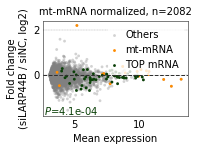

In [62]:
# Configurations
savefig = True
minifig = True
ttest=True

figsize = 5.2, 3.5
subsets = ["mtgenes", "topgenes"]
mtgenes_cutoff = 1000
scaler = 1000
normed_tagcnt_cutoff = 8.5

styles = ["../polya.mplstyle"]
if minifig is True:
    styles.append("../mini.mplstyle")
    figsize = list(map(lambda x:x/2, figsize))

def get_mtnormed_tagcnts(smp, df):
    global mtgenes, mtgenes_cutoff, scaler, normed_tagcnt_cutoff
    tagcnts = df[[f"{smp}:polyA_tag_count", f"{smp}:nonpolyA_tag_count"]].sum(axis=1).dropna()
    mtgenes_tagcnts = tagcnts[mtgenes]
    mtgenes_tagcnts = mtgenes_tagcnts[mtgenes_tagcnts >= mtgenes_cutoff]
    normed = tagcnts / gmean(mtgenes_tagcnts) * scaler
    
    return normed[normed >= normed_tagcnt_cutoff]
    
tagcnts_ctrl = get_mtnormed_tagcnts(ctrl, df_glstats)

with plt.style.context(styles):
    default_colors = sns.color_palette()
    colors_by_smp = json.load(open("../colors_by_smp.json","r"))
    colors = [colors_by_smp.get(smp, default_colors[si]) for si, smp in enumerate(samples)]
    for smp in samples:
        if smp == ctrl: continue
        fig, ax = plt.subplots(figsize=figsize)
        
        tagcnts = get_mtnormed_tagcnts(smp, df_glstats)
        
        x, y = tagcnts_ctrl.align(tagcnts, join="inner")
        
        M = np.log2(y) - np.log2(x)
        A = np.log2(x*y) / 2       
        
        ax.scatter(A, M, s=8, color='gray', edgecolor="none", alpha=0.35, rasterized=True, label="Others")
        
        for subset in subsets:
            subset_genes = gene_lists[subset]
            ax.scatter(A[subset_genes], M[subset_genes], s=8, color=colors_by_smp[subset], edgecolor='none', rasterized=True, label=subset_labels[subset])
        
        if ttest:
            pval = ttest_1samp(M[gene_lists['topgenes']].dropna(), 0).pvalue / 2
            if pval < 0.01:
                ax.text(0.01, 0.01, "$\mathit{P}$=%.1e"%(pval), transform=ax.transAxes, color=colors_by_smp['topgenes'], ha="left")
            else:
                ax.text(0.01, 0.01, "$\mathit{P}$=%.2f"%(pval), transform=ax.transAxes, color=colors_by_smp['topgenes'], ha="left")

            
        
        ax.axhline(y=0, ls="--", lw=1)
        ax.grid(axis="y")
#         ax.set_xlim([3, 15])
#         ax.set_ylim([-2.8, 1.2])
        ax.set_xlabel("Mean expression")
        ax.set_ylabel(f"Fold change\n({smp.split('-')[0]} / {ctrl}, log2)")
        ax.set_title(f"mt-mRNA normalized, n={len(M)}", fontsize="medium")
        ax.legend(loc="best", handlelength=0.5)
        
#         ax.text(0.05, 0.83, "n={}".format(len(M)), transform=ax.transAxes, ha="left")
        
        fname_adduct = ""
        if minifig: fname_adduct += "_mini"

        if savefig is True:
            outfigpath = workdir/work/"plots/ma_plot_{}_mt-normed_{}{}.pdf".format(work, smp, fname_adduct)
            plt.savefig(outfigpath, bbox_inches='tight', dpi=300)
            print(outfigpath, 'saved')
            
        plt.show()



### RPM normalization and a statistical test for the TOP gene preference

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Helvetica Neue, Arial, sans-serif


((11, 4), (679, 698))
2.8269513991163477 0.07298992473895541
((32, 25), (679, 698))
1.315817378497791 0.34530574193719016


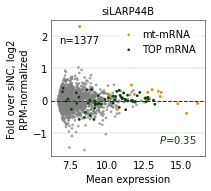

In [14]:
savefig = False

figsize = 5.5, 5
minifig = True
fishertest = True
subsets = ["mtgenes", "topgenes"]
mtgenes_cutoff = 0
scaler = 1000
normed_tagcnt_cutoff = 100

styles = ["../polya.mplstyle"]
if minifig is True:
    styles.append('mini')
    figsize = list(map(lambda x:x/2, figsize))

ctrl_tagcnts = df_glstats[["{}:polyA_tag_count".format(ctrl), "{}:nonpolyA_tag_count".format(ctrl)]].sum(axis=1).dropna()
ctrl_normed = ctrl_tagcnts / (ctrl_tagcnts.sum() / 1000000)
ctrl_normed = ctrl_normed[ctrl_normed >= normed_tagcnt_cutoff]
with plt.style.context(styles):
    default_colors = sns.color_palette()
    colors_by_smp = json.load(open("../colors_by_smp.json","r"))
    colors = [colors_by_smp.get(smp, default_colors[si]) for si, smp in enumerate(samples)]
    for smp in samples:
        if smp == ctrl: continue
        fig, ax = plt.subplots(figsize=figsize)
        
        tagcnts = df_glstats[["{}:polyA_tag_count".format(smp), "{}:nonpolyA_tag_count".format(smp)]].sum(axis=1).dropna()
        normed = tagcnts / (tagcnts.sum() / 1000000)

        # Normed minimum tag count filter
        
        normed = normed[normed >= normed_tagcnt_cutoff]
        
        x, y = ctrl_normed.align(normed, join="inner")

        M = np.log2(y) - np.log2(x)
        A = np.log2(x*y) / 2

        ax.scatter(A, M, s=7, color="grey", edgecolor="none", alpha=0.75, rasterized=True)
        
        # Fischer's exact test for enrichment or depletion of the subset
        if fishertest is True:
            fisher_res = dict()
            for subset in subsets:
                subset_genes = gene_lists[subset]
                tbl = ( (M.reindex(subset_genes) > 0).sum(),(M.reindex(subset_genes) <= 0).sum() ), \
                      ( (M > 0).sum(), (M <= 0).sum() )
                odds, pval = fisher_exact(tbl)
                print( tbl )
                print(odds, pval)
                fisher_res[subset] = (odds, pval)
                
        # Marking subsets
        for subset in subsets:
            subset_genes = gene_lists[subset]
            ax.scatter(A.reindex(subset_genes), M.reindex(subset_genes), s=7, color=colors_by_smp[subset], edgecolor="none", label=subset_labels[subset], zorder=7)
            
        ax.axhline(y=0, ls="--", lw=1)
        ax.grid(axis='y')
        ax.set_xlabel("Mean expression")
        ax.set_ylabel(f"Fold over {ctrl}, log2\nRPM-normalized")
        ax.set_title(smp.split('-')[0], fontsize='medium')
        ax.legend(loc="upper right")
        
        ax.text(0.05, 0.83, "n={}".format(len(M)), transform=ax.transAxes, ha="left")
        
        if fishertest is True:
            for mi, subset in enumerate(subsets):
                if subset == "mtgenes": continue
                odds, pval = fisher_res[subset]
                if pval < 0.01:
                    ax.text(0.95, 0.1, "$\mathit{P}$=%.1e"%(pval), transform=ax.transAxes, color=colors_by_smp[subset], ha="right")
                else:
                    ax.text(0.95, 0.1, "$\mathit{P}$=%.2f"%(pval), transform=ax.transAxes, color=colors_by_smp[subset], ha="right")
                    
        fname_adduct = ""
        if minifig: fname_adduct += "_mini"
        
        if savefig is True:
            outfigpath = "../plots/ma_plot_{}_rpm-normed_{}{}.pdf".format(work, smp, fname_adduct)
            plt.savefig(outfigpath, bbox_inches="tight", dpi=300)
            print(outfigpath, 'saved')
            
        plt.show()
